In [1]:
import pandas_datareader.data as pdr

def get_stock_data(code):
  df = pdr.DataReader("{}.JP".format(code), "stooq").sort_index()
  return df

In [2]:
!pip install mplfinance

     |████████████████████████████████| 70 kB 2.6 MB/s 


In [3]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2022-05-19 01:45:14--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-05-19 01:45:15--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-05-19 01:45:15--  http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving nchc.dl.sourceforge.n

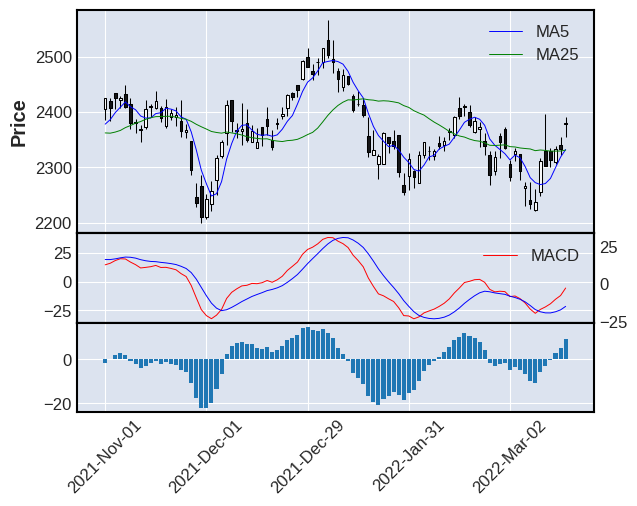

In [ ]:
import mplfinance as mpf
import datetime as dt
import numpy as np
import talib as ta

df = get_stock_data(1928)  # 積水ハウス
close = df["Close"]

df['ma5'] = ta.SMA(close ,timeperiod=5)
df['ma25'] = ta.SMA(close ,timeperiod=25)

# MACD、シグナル、ヒストグラムを算出
macd, macdsignal, hist = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df['macd'] = macd
df['macd_signal'] = macdsignal
df['hist'] = hist

# 2021.11〜2022.3の株価データを表示
rdf = df[dt.datetime(2021,11,1):dt.datetime(2022,3,31)]

apd  = [
          # 5日移動平均線
          mpf.make_addplot(rdf['ma5'], color='blue', 
                                panel=0, width=0.7),
          # 25日移動平均線
          mpf.make_addplot(rdf['ma25'], color='green', 
                                panel=0, width=0.7),
          # MACD
          mpf.make_addplot(rdf['macd'], panel=1, 
                                width=0.7, color='red'),
          # シグナル
          mpf.make_addplot(rdf['macd_signal'], panel=1, 
                                width=0.7, color='blue'),
          # ヒストグラム
          mpf.make_addplot(rdf['hist'], panel=2, type='bar')
      ]

fig, axes = mpf.plot(rdf, type="candle", figratio=(5,4), 
                     addplot=apd, returnfig=True)
axes[0].legend(["MA5", "MA25"])
axes[2].legend(["MACD", "SIGNAL"])
fig.show()

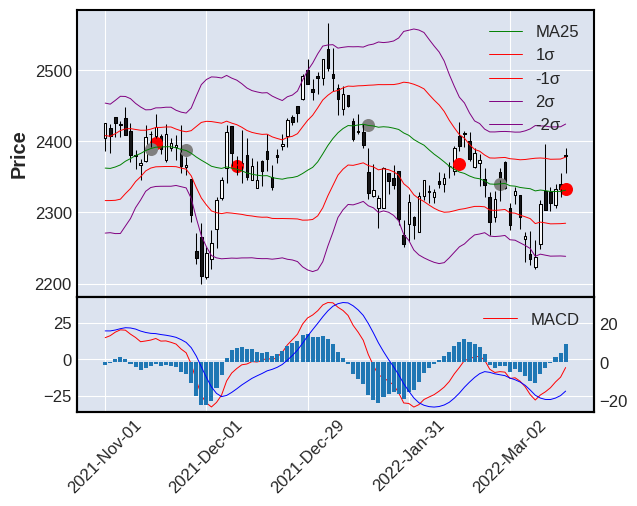

In [ ]:
df = get_stock_data(1928)   # 日本製鉄
close = df["Close"]

df['ma5'] = ta.SMA(close ,timeperiod=5)
df['ma25'] = ta.SMA(close ,timeperiod=25)

ma5, ma25 = df['ma5'], df['ma25']
cross  = ma5 > ma25

cross_shift = cross.shift(1)
temp_gc = (cross != cross_shift) & (cross == True)
temp_dc  = (cross != cross_shift) & (cross == False)

# ゴールデンクロス発生日であればMA5の値、それ以外はNaN
gc = [m if g == True else np.nan for g, m in zip(temp_gc, ma5)]

# デッドクロス発生日であればMA25の値、それ以外はNan
dc = [m if d == True else np.nan for d, m in zip(temp_dc, ma25)]

# データフレームのカラムとして保存
df["gc"], df["dc"] = gc, dc


macd, macdsignal, hist = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df['macd'] = macd
df['macd_signal'] = macdsignal
df['hist'] = hist

df['upper1'], df['middle'], df['lower1'] = ta.BBANDS(close, timeperiod=25, nbdevup=1, nbdevdn=1, matype=0)
df['upper2'], df['middle'], df['lower2'] = ta.BBANDS(close, timeperiod=25, nbdevup=2, nbdevdn=2, matype=0)

# 2021.11〜2022.3の株価データを表示
rdf = df[dt.datetime(2021,11,1):dt.datetime(2022,3,31)]

apd  = [
          # 25日移動平均線
          mpf.make_addplot(rdf['ma25'], color='green', 
                                panel=0, width=0.7), 
          # ゴールデンクロス
          mpf.make_addplot(rdf["gc"],type='scatter',
                              markersize=70,marker='o',color='red'),
          # デッドクロス
          mpf.make_addplot(rdf["dc"],type='scatter',
                              markersize=70,marker='o',color='gray'),
          # 1σ
          mpf.make_addplot(rdf['upper1'], panel=0, 
                              color='red', width=0.7),
          # -1σ
          mpf.make_addplot(rdf['lower1'], panel=0, 
                              color='red', width=0.7),
          # 2σ
          mpf.make_addplot(rdf['upper2'], panel=0, 
                              color='purple', width=0.7),
          # -2σ
          mpf.make_addplot(rdf['lower2'], panel=0, 
                              color='purple', width=0.7),
          # MACD
          mpf.make_addplot(rdf['macd'], panel=1, 
                                color='red', width=0.7),
          # シグナル
          mpf.make_addplot(rdf['macd_signal'], panel=1, 
                                color='blue', width=0.7),
          # ヒストグラム
          mpf.make_addplot(rdf['hist'], panel=1, type='bar') 
      ]

fig, axes = mpf.plot(rdf, type="candle", figratio=(5,4), 
                      addplot=apd, returnfig=True)
axes[0].legend(["MA25", "1σ", "-1σ", "2σ", "-2σ"])
axes[2].legend(["MACD", "SIGNAL"])
fig.show()